<a href="https://colab.research.google.com/github/udAAbu/JSL_Project/blob/main/radio_joint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import time
import os
import copy
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter("ignore")

plt.ion()
pd.set_option("display.max_colwidth", None)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Path

- (Important) These paths should be changed to the paths to each folder in your google drive.

In [30]:
# Joint space loss CSV file
JSL_path = "/content/drive/MyDrive/OAI_data/JSL.csv"
Image_dir = "/content/drive/MyDrive/OAI_data/complete_images/"

### Load data

- Load the joint space loss csv file and available images. 
- filter the data (get rid of rows without label or image)
- should have 4163 useful records.

In [40]:
JSL_data = pd.read_csv(JSL_path)
available_images = os.listdir(Image_dir)

JSL_data['Img_id'] = JSL_data.apply(lambda x: x['ID'] + '.png', axis = 1)
JSL_data["Img_path"] = JSL_data.apply(lambda x: Image_dir + x['Img_id'], axis = 1)

#filter out those records without label or without images
table = JSL_data[(JSL_data['Img_id'].isin(available_images)) & (JSL_data['JSL_Prog'].isna() == False)]
table.head()

,ID,Age,Sex,BMI,Race,BL_KL_grade,Knee_Injury,Alignmnet_TRIN,Alignment_degree,JSL_Prog,Img_id,Img_path
0,9001897_1,72,1,25.9,1.0,3.0,1.0,1.0,6.0,1.0,9001897_1.png,/content/drive/MyDrive/OAI_data/complete_images/9001897_1.png
1,9002116_1,61,1,36.5,2.0,2.0,0.0,1.0,4.0,1.0,9002116_1.png,/content/drive/MyDrive/OAI_data/complete_images/9002116_1.png
2,9003380_2,64,1,33.1,1.0,1.0,0.0,1.0,5.0,1.0,9003380_2.png,/content/drive/MyDrive/OAI_data/complete_images/9003380_2.png
3,9004905_2,66,2,36.2,2.0,2.0,0.0,2.0,-3.0,1.0,9004905_2.png,/content/drive/MyDrive/OAI_data/complete_images/9004905_2.png
4,9009957_1,75,2,26.8,1.0,2.0,0.0,0.0,0.0,1.0,9009957_1.png,/content/drive/MyDrive/OAI_data/complete_images/9009957_1.png


### Preprocess the table data

- impute missing values
- convert Race and KL_grade to categorical features
- dummy all the categorical features

In [41]:
#impute missing alignment_degree with mean (very few)
alignment_degree_avg = np.mean(table['Alignment_degree'])
table['Alignment_degree'] = table['Alignment_degree'].fillna(alignment_degree_avg)

#impute missing BMI with mean (very few)
BMI_avg = np.mean(table['BMI'])
table['BMI'] = table['BMI'].fillna(BMI_avg)

#impute missing knee_Injury with 0
table['Knee_Injury'] = table['Knee_Injury'].fillna(0)

table['Sex'] = table['Sex'].apply(lambda x: 0 if x == 1 else 1)

table['Race'] = table['Race'].astype(str)
table['BL_KL_grade'] = table['BL_KL_grade'].astype(str)

cols = ['Race', 'BL_KL_grade']
table = pd.get_dummies(table, columns = cols)
table.head()

,ID,Age,Sex,BMI,Knee_Injury,Alignmnet_TRIN,Alignment_degree,JSL_Prog,Img_id,Img_path,Race_0.0,Race_1.0,Race_2.0,Race_3.0,BL_KL_grade_0.0,BL_KL_grade_1.0,BL_KL_grade_2.0,BL_KL_grade_3.0,BL_KL_grade_4.0
0,9001897_1,72,0,25.9,1.0,1.0,6.0,1.0,9001897_1.png,/content/drive/MyDrive/OAI_data/complete_images/9001897_1.png,0,1,0,0,0,0,0,1,0
1,9002116_1,61,0,36.5,0.0,1.0,4.0,1.0,9002116_1.png,/content/drive/MyDrive/OAI_data/complete_images/9002116_1.png,0,0,1,0,0,0,1,0,0
2,9003380_2,64,0,33.1,0.0,1.0,5.0,1.0,9003380_2.png,/content/drive/MyDrive/OAI_data/complete_images/9003380_2.png,0,1,0,0,0,1,0,0,0
3,9004905_2,66,1,36.2,0.0,2.0,-3.0,1.0,9004905_2.png,/content/drive/MyDrive/OAI_data/complete_images/9004905_2.png,0,0,1,0,0,0,1,0,0
4,9009957_1,75,1,26.8,0.0,0.0,0.0,1.0,9009957_1.png,/content/drive/MyDrive/OAI_data/complete_images/9009957_1.png,0,1,0,0,0,0,1,0,0


### train, val, test
- Use **balance** arg to control the balance of two classes. You can set **balance=False** if you don't want the balanced dataset. 

In [96]:
def train_val_test(table, test_size, val_size, balance = True):
    if balance:
        balanced_table = pd.concat([table[table['JSL_Prog'] == 0].sample(frac = 0.5), table[table['JSL_Prog'] == 1]])
        print(balanced_table['JSL_Prog'].value_counts())

        X_train, X_test, y_train, y_test = train_test_split(balanced_table.drop(columns = 'JSL_Prog'), balanced_table['JSL_Prog'], test_size = test_size, random_state = 1997)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size, random_state = 1997)
    else:
        X_train, X_test, y_train, y_test = train_test_split(table.drop(columns = 'JSL_Prog'), table['JSL_Prog'], test_size = test_size, random_state = 1997)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size, random_state = 1997)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [97]:
#these are the risk factors we will include
use_cols = ['Age', 'Sex', 'BMI', 'Knee_Injury', 'Alignment_degree', \
            'Race_0.0', 'Race_1.0', 'Race_2.0', 'Race_3.0', 'BL_KL_grade_0.0', 'BL_KL_grade_1.0', 'BL_KL_grade_2.0', 'BL_KL_grade_3.0', 'BL_KL_grade_4.0']

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(table, test_size = 300, val_size = 300, balance = True)

joint_data = {
    "train": {"df": X_train, "cols": use_cols, "labels": y_train},
    "val": {"df": X_val, "cols": use_cols, "labels": y_val},
    "test": {"df":X_test, "cols": use_cols, "labels": y_test}
}

0.0    1406
1.0    1351
Name: JSL_Prog, dtype: int64


### CustomDataset
- load image and risk factors together



In [98]:
class CustomDataset(Dataset):
    def __init__(self, df, cols, labels, transform = None):
        """
        output: (Image tensor, risk factors tensor), label
        """
        self.images = df["Img_path"].tolist()
        self.factors = df[cols].values
        self.labels = labels.tolist()
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        risk_factors = self.factors[idx, :]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)
        
        risk_factors = torch.tensor(risk_factors, dtype = torch.float)
        label = torch.tensor(label, dtype = torch.int64)
        return (img, risk_factors), label

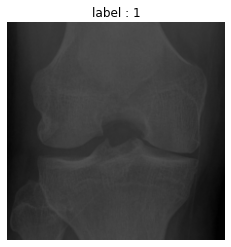

In [100]:
#example of usage of CustomDataset
train_dataset = CustomDataset(X_train, use_cols, y_train, transform=transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]))

(temp_img, temp_tab), temp_lab = train_dataset[2]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
plt.title("label : " + str(temp_lab.item()))
plt.axis('off')
plt.show()

### Load data for batch training
- You can add more data augmentation if you want. (more can be found in: https://pytorch.org/vision/stable/transforms.html) 
    - transforms.ColorJitter()
    - transforms.RandomHorizontalFlip()
    - transforms.RandomAffine
    - ...
- You can decide whether to normalize the image by setting **normalize = True/False**.



In [101]:
def imshow(inp, title=None, unnormalize = False):
    """
    Helper function to visualize one batch of image tensor
    """
    inp = inp.numpy().transpose((1, 2, 0))

    if unnormalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    plt.imshow(inp, cmap = plt.cm.bone)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [102]:
def load_joint_data(data, normalize = False, show_images = True):
    """
    loading data into dataloaders
    
    data: the dictionary that contains all the train/val/test
    normalize: whether to normalize image by ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    show_images: whether to show one batch of images
    """
    if normalize:
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomRotation(degrees = 5),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }
    else:
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomRotation(degrees = 5),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]),
            'val': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]),
            'test': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]),
        }
    
    image_datasets = {x: CustomDataset(data[x]['df'], data[x]['cols'], data[x]['labels'], data_transforms[x]) \
                      for x in ['train', 'val', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

    #indices = {x: list(range(dataset_sizes[x])) for x in ['train', 'val', 'test']}

    #sampler = {x: SubsetRandomSampler(indices[x]) for x in ["train", 'val', 'test']}

    dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) \
                   for x in ['train', 'val', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

    if show_images:
        if normalize == True:
            # Get a batch of training data
            (img_inputs, _), classes = next(iter(dataloaders['train']))
            # Make a grid from batch
            out = torchvision.utils.make_grid(img_inputs)
            imshow(out, title=[str(x.item()) for x in classes], unnormalize = True)
        else:
            # Get a batch of training data
            (img_inputs, _), classes = next(iter(dataloaders['train']))
            # Make a grid from batch
            out = torchvision.utils.make_grid(img_inputs)
            imshow(out, title=[str(x.item()) for x in classes])

    return dataloaders, dataset_sizes, image_datasets

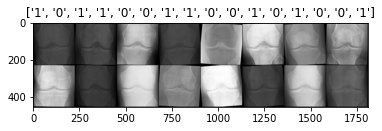

{'train': 2157, 'val': 300, 'test': 300}


In [136]:
dataloaders, dataset_sizes, image_datasets = load_joint_data(joint_data, normalize = False, show_images=True)
print(dataset_sizes)

### Approach 1: Training single task CNN (Only predicting radio progression)


In [138]:
def get_vgg_model(KL_pretrained = False):
    """
    initialize vgg model, loss function, optimizer, scheduler
    """
    model_ft = models.vgg16(pretrained = True)
    model_ft.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    
    if KL_pretrained == True:
        model_ft.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(512, 5),
            )

        #path to the model predicting KL_grade
        PATH = '/content/drive/MyDrive/DL_models/KL_prediction.pt'
        model_ft.load_state_dict(torch.load(PATH))
        print("Load the pretrained weights")
    
    model_ft.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 1),
    )

    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model_ft.parameters(), lr = 0.00005)

    # Decay LR by a factor of 0.5 every 5 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose = True)

    return model_ft.to(device), criterion, optimizer, scheduler

In [70]:
def train_image_model(model, criterion, optimizer, scheduler, threshold = 0.5, num_epochs=25):
    """
    this training function trains the CNN model without including the risk factors. 
    """
    since = time.time()

    #save the weights of best model (highest AUC)
    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc, best_auc = 0.0, 0.0
    train_acc_history, val_acc_history = [], []

    #sigmoid activation for the final output
    sigmoid = nn.Sigmoid()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                output_score, y_true = [], []

            running_loss = 0.0
            running_corrects = 0
            correct_list = []

            # Iterate over data.
            for (img_inputs, _), labels in dataloaders[phase]:
                inputs = img_inputs.to(device)
                labels = labels.float().to(device)
            
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # output logits (action)
                    outputs = model(inputs).squeeze(1)
                    batch_correct = (sigmoid(outputs) > threshold) == labels
                    # compute loss over logits
                    batch_loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        batch_loss.backward()
                        optimizer.step()
                    else:
                        # save the output probability and true label to compute AUC later
                        output_score += sigmoid(outputs).cpu().detach().numpy().tolist()
                        y_true += labels.cpu().detach().numpy().tolist()
                
                # statistics
                running_loss += batch_loss.item() * inputs.shape[0]
                correct_list += batch_correct.cpu().numpy().tolist()

                # clear cache
                del inputs, labels, outputs, batch_loss, batch_correct
                torch.cuda.empty_cache()

            if phase == 'train':
                scheduler.step()

            # train/val epoch average loss
            epoch_loss = running_loss / dataset_sizes[phase]
            # train/val epoch accuracy
            epoch_acc = np.mean(correct_list)

            if phase == 'val':
                epoch_auc = roc_auc_score(y_true, output_score)
                print('{} Loss: {:.4f} Acc: {:.4f}, AUC: {:.4f}'.format(
                                phase, epoch_loss, epoch_acc, epoch_auc))
                val_acc_history.append(epoch_acc)
            else:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                phase, epoch_loss, epoch_acc))
                train_acc_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_auc > best_auc:
            #if phase == 'val' and epoch_loss < model_score:
                best_auc = epoch_auc
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val AUC:{:.4f}, Acc: {:4f}'.format(best_auc, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [71]:
def eval_image_model(model, criterion, threshold = 0.5, eval_set = 'val'):
    """
    this evaluation function evaluates the CNN model. 
    """
    model.eval()

    since = time.time()
    loss_eval, acc_eval= 0, 0

    # y_hat: predictions
    # output_score: probabilities (compute AUC)
    # y_true: ground truth
    y_hat, output_score, y_true = [], [], []
    sigmoid = nn.Sigmoid()
    
    test_batches = len(dataloaders[eval_set])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[eval_set]):
        if i % 100 == 0:
            print("\rbatch {}/{}".format(i, test_batches), end='', flush=True)
            
        (img_inputs, _), labels = data

        inputs = img_inputs.to(device)
        labels = labels.float().to(device)

        outputs = model(inputs).squeeze(1)
        is_correct = (sigmoid(outputs) > threshold) == labels
        batch_loss = criterion(outputs, labels)

        loss_eval += batch_loss.item() * inputs.shape[0]
        acc_eval += torch.sum(is_correct)

        output_score += sigmoid(outputs).cpu().detach().numpy().tolist()
        y_true += labels.cpu().detach().numpy().tolist()
        y_hat += (sigmoid(outputs) > threshold).cpu().numpy().tolist()

        del inputs, labels, outputs, batch_loss
        torch.cuda.empty_cache()
        
    avg_loss = loss_eval/ dataset_sizes[eval_set]
    avg_acc = acc_eval / dataset_sizes[eval_set]
    auc_score = roc_auc_score(y_true, output_score)
    precision = precision_score(y_true, y_hat)
    recall = recall_score(y_true, y_hat)
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print("Avg auc (test): {:.4f}".format(auc_score))
    print("Avg precision: {:.4f} recall: {:.4f}".format(precision, recall))
    print('-' * 10)

    cm = confusion_matrix(y_true, y_hat)
    df_cm = pd.DataFrame(cm, index = [0, 1], columns = [0, 1])
    plt.figure(figsize = (8, 6))
    sns.heatmap(df_cm, annot=True, fmt='.5g')
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.title("confusion matrix")
    plt.show()

    return output_score, y_true, y_hat

In [140]:
model_ft, criterion, optimizer, scheduler = get_vgg_model(KL_pretrained = True)
summary(model_ft, (3, 224, 224))

Adjusting learning rate of group 0 to 5.0000e-05.
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [141]:
best_model, train_acc_hist, val_acc_hist = \
train_image_model(model_ft, criterion, optimizer, scheduler, threshold = 0.5, num_epochs=15)

Epoch 0/14
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 0.6771 Acc: 0.5865
val Loss: 0.6685 Acc: 0.6500, AUC: 0.6738
Epoch 1/14
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 0.6437 Acc: 0.6467
val Loss: 0.6505 Acc: 0.6500, AUC: 0.6987
Epoch 2/14
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 0.6143 Acc: 0.6597
val Loss: 0.6359 Acc: 0.6333, AUC: 0.6805
Epoch 3/14
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 0.5966 Acc: 0.6889
val Loss: 0.6361 Acc: 0.6633, AUC: 0.6909
Epoch 4/14
----------
Adjusting learning rate of group 0 to 2.5000e-05.
train Loss: 0.5596 Acc: 0.7065
val Loss: 0.6440 Acc: 0.6533, AUC: 0.7046
Epoch 5/14
----------
Adjusting learning rate of group 0 to 2.5000e-05.
train Loss: 0.5001 Acc: 0.7552
val Loss: 0.6765 Acc: 0.6267, AUC: 0.6851
Epoch 6/14
----------
Adjusting learning rate of group 0 to 2.5000e-05.
train Loss: 0.4673 Acc: 0.7812
val Loss: 0.7415 Acc: 0.640

Evaluating model
----------
batch 0/19
Evaluation completed in 0m 3s
Avg loss (test): 0.6306
Avg acc (test): 0.6733
Avg auc (test): 0.7210
Avg precision: 0.6710 recall: 0.6887
----------


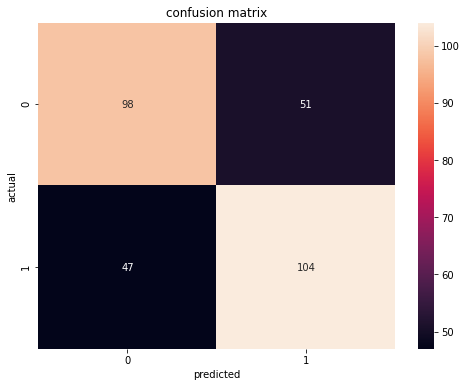

In [142]:
output_score, y_true, output_list = eval_image_model(best_model, criterion, threshold = 0.5, eval_set = 'test')

### Visualize the saliency map

In [135]:
print(X_test['Img_path'][:5], y_test.tolist()[:5])

1230    /content/drive/MyDrive/OAI_data/complete_images/9903903_1.png
279     /content/drive/MyDrive/OAI_data/complete_images/9254422_1.png
307     /content/drive/MyDrive/OAI_data/complete_images/9273964_1.png
890     /content/drive/MyDrive/OAI_data/complete_images/9675129_2.png
1113    /content/drive/MyDrive/OAI_data/complete_images/9833809_1.png
Name: Img_path, dtype: object [1.0, 1.0, 1.0, 1.0, 1.0]


0.9118573665618896
0.7133800983428955


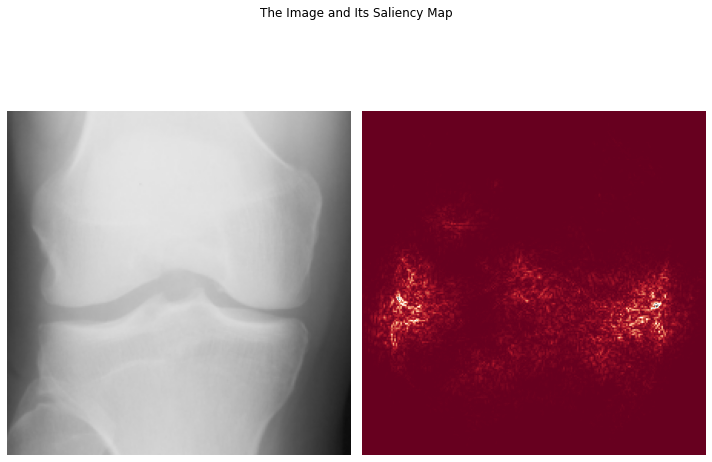

In [145]:
from PIL import Image

# Open the image file
image = Image.open("/content/drive/MyDrive/OAI_data/complete_images/9833809_1.png")

# Set up the transformations
transform_ = transforms.Compose([
        transforms.Resize((224, 224)),
		transforms.ToTensor(),
])

# Transforms the image
image = transform_(image)
image = image.reshape(1, 3, 224, 224).to(device)
image.requires_grad_()

model_ft.eval()
output = model_ft(image)
print(output.squeeze().item())
m = nn.Sigmoid()
print(m(output).squeeze().item())

# Catch the output
# Do backpropagation to get the derivative of the output based on the image
output.backward()
saliency, _ = torch.max(image.grad.data.abs(),dim=1)

saliency = saliency.reshape(224, 224)

# Reshape the image
image = image.reshape(-1, 224, 224)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2, figsize = (10, 8))
ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0), cmap =  'RdGy')
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap =  'RdGy')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

### PR curve and ROC

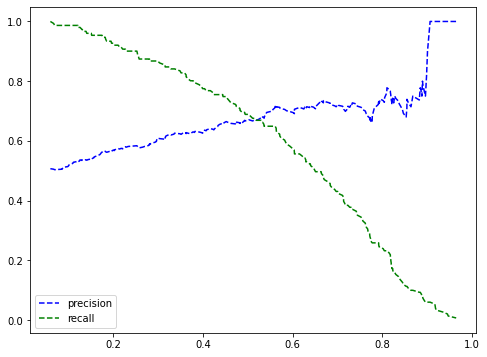

In [146]:
#Precision recall curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_true, output_score)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize = (8, 6))
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

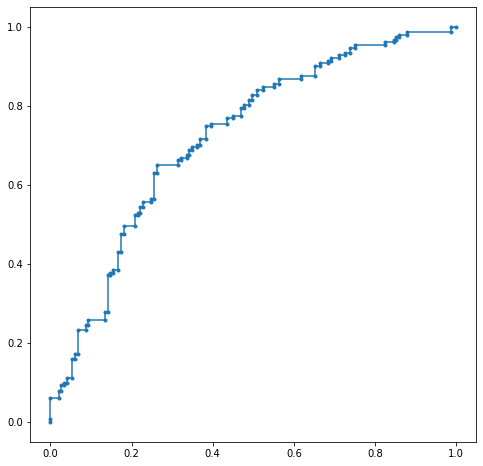

In [147]:
#ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, output_score)
plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, marker='.')
plt.show()

In [148]:
#save model weights
PATH = '/content/drive/MyDrive/DL_models/KL_based_vgg.pt'
torch.save(model_ft.state_dict(), PATH)

### Training function for the Joint Model (Image + Risk factors)

In [162]:
def train_joint_model(model, criterion, optimizer, scheduler, freeze_cnn = False, threshold = 0.5, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc, best_auc = 0.0, 0.0

    # accuracy history for training and validation
    train_acc_history, val_acc_history = [], []

    #sigmoid activation for the final output
    sigmoid = nn.Sigmoid()
    
    if freeze_cnn:
        for param in model.cnn.parameters():
            param.requires_grad = False

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        if freeze_cnn == False:
            #only freeze cnn parameters in the first epoch
            if epoch == 0:
                for param in model.cnn.parameters():
                    param.requires_grad = False
                optimizer = optim.Adam(joint_model.parameters(), lr = 0.001)
            #unfreeze all parameters
            else:
                for param in model.cnn.parameters():
                    param.requires_grad = True
                optimizer = optim.Adam(joint_model.parameters(), lr = 0.00005)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                output_score, y_true = [], []

            running_loss = 0.0
            running_corrects = 0
            correct_list = []

            # Iterate over data.
            for (image_inputs, tab_inputs), labels in dataloaders[phase]:
                
                image_inputs = image_inputs.to(device)
                labels = labels.float().to(device)
                tab_inputs = tab_inputs.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # output logits (action)
                    outputs = model(image_inputs, tab_inputs).squeeze(1)
                    batch_correct = (sigmoid(outputs) > threshold) == labels
                    # compute loss over logits
                    batch_loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        batch_loss.backward()
                        optimizer.step()
                    else:
                        # save the output probability and true label to compute AUC
                        output_score += sigmoid(outputs).cpu().detach().numpy().tolist()
                        y_true += labels.cpu().detach().numpy().tolist()
                
                # statistics
                running_loss += batch_loss.item() * image_inputs.shape[0]
                correct_list += batch_correct.cpu().numpy().tolist()

                # clear cache
                del image_inputs, tab_inputs, labels, outputs, batch_loss, batch_correct
                torch.cuda.empty_cache()

            if phase == 'train':
                scheduler.step()

            # train/val epoch average loss
            epoch_loss = running_loss / dataset_sizes[phase]
            # train/val epoch accuracy
            epoch_acc = np.mean(correct_list)

            if phase == 'val':
                epoch_auc = roc_auc_score(y_true, output_score)
                print('{} Loss: {:.4f} Acc: {:.4f}, AUC: {:.4f}'.format(
                                phase, epoch_loss, epoch_acc, epoch_auc))
                val_acc_history.append(epoch_acc)
                
                #scheduler.step(epoch_auc)
            else:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                phase, epoch_loss, epoch_acc))
                train_acc_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_auc > best_auc:
            #if phase == 'val' and epoch_loss < model_score:
                best_auc = epoch_auc
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            #scheduler.step()
    
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val AUC:{:.4f}, Acc: {:4f}'.format(best_auc, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [163]:
def eval_joint_model(model, criterion, threshold = 0.5, eval_set = 'val'):
    model.eval()

    since = time.time()
    loss_eval, acc_eval= 0, 0

    y_hat, output_score, y_true = [], [], []
    sigmoid = nn.Sigmoid()
    
    test_batches = len(dataloaders[eval_set])
    print("Evaluating model")
    print('-' * 10)
    
    for (image_inputs, tab_inputs), labels in dataloaders[eval_set]:

        image_inputs = image_inputs.to(device)
        labels = labels.float().to(device)
        tab_inputs = tab_inputs.to(device)
    
        outputs = model(image_inputs, tab_inputs).squeeze(1)
        is_correct = (sigmoid(outputs) > threshold) == labels
        batch_loss = criterion(outputs, labels)

        loss_eval += batch_loss.item() * image_inputs.shape[0]
        acc_eval += torch.sum(is_correct)

        output_score += sigmoid(outputs).cpu().detach().numpy().tolist()
        y_true += labels.cpu().detach().numpy().tolist()
        y_hat += (sigmoid(outputs) > threshold).cpu().numpy().tolist()

        del image_inputs, tab_inputs, labels, outputs, batch_loss
        torch.cuda.empty_cache()
        
    avg_loss = loss_eval/ dataset_sizes[eval_set]
    avg_acc = acc_eval / dataset_sizes[eval_set]
    auc_score = roc_auc_score(y_true, output_score)
    precision = precision_score(y_true, y_hat)
    recall = recall_score(y_true, y_hat)
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print("Avg auc (test): {:.4f}".format(auc_score))
    print("Avg precision: {:.4f} recall: {:.4f}".format(precision, recall))
    print('-' * 10)

    cm = confusion_matrix(y_true, y_hat)
    df_cm = pd.DataFrame(cm, index = [0, 1], columns = [0, 1])
    plt.figure(figsize = (8, 6))
    sns.heatmap(df_cm, annot=True, fmt='.5g')
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.title("confusion matrix")
    plt.show()

    return output_score, y_true, y_hat

In [167]:
class Joint_Model(nn.Module):
    def __init__(self, cnn_path):
        super(Joint_Model, self).__init__()
        self.cnn = models.vgg16(pretrained = True)
        self.cnn.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.cnn.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1),
        )

        PATH = cnn_path
        print(self.cnn.load_state_dict(torch.load(PATH)))

        self.cnn.classifier = nn.Sequential(nn.Flatten())
        self.fc1 = nn.Linear(14, 128)
        self.head = nn.Linear(512 + 128, 1)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        x2 = self.fc1(data)

        x = torch.cat((x1, x2), dim=1)
        x = self.head(x)
        return x
        

def get_joint_model(cnn_path, freeze_cnn = False):

    joint_model = Joint_Model(cnn_path)

    criterion = nn.BCEWithLogitsLoss()

    if freeze_cnn:
        optimizer = optim.Adam(joint_model.parameters(), lr = 0.001)
    else:
        optimizer = optim.Adam(joint_model.parameters(), lr = 0.00005)

    # Decay LR by a factor of 0.8 every 3 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8, verbose = True)

    return joint_model.to(device), criterion, optimizer, scheduler

In [174]:
#freeze the CNN weights
joint_model, criterion, optimizer, scheduler = get_joint_model(cnn_path = '/content/drive/MyDrive/DL_models/KL_based_vgg.pt', freeze_cnn=True)
best_joint_model, train_acc_hist, val_acc_hist = train_joint_model(joint_model, criterion, optimizer, scheduler, freeze_cnn=True, threshold = 0.5, num_epochs=10)

<All keys matched successfully>
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 0.5708 Acc: 0.6968
val Loss: 0.7279 Acc: 0.6433, AUC: 0.7058
Epoch 1/9
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 0.5225 Acc: 0.7427
val Loss: 0.7039 Acc: 0.6667, AUC: 0.7117
Epoch 2/9
----------
Adjusting learning rate of group 0 to 8.0000e-04.
train Loss: 0.5169 Acc: 0.7432
val Loss: 0.6914 Acc: 0.6633, AUC: 0.7059
Epoch 3/9
----------
Adjusting learning rate of group 0 to 8.0000e-04.
train Loss: 0.5022 Acc: 0.7413
val Loss: 0.7336 Acc: 0.6667, AUC: 0.7039
Epoch 4/9
----------
Adjusting learning rate of group 0 to 8.0000e-04.
train Loss: 0.5032 Acc: 0.7506
val Loss: 0.7191 Acc: 0.6433, AUC: 0.7151
Epoch 5/9
----------
Adjusting learning rate of group 0 to 6.4000e-04.
train Loss: 0.4957 Acc: 0.7617
val Loss: 0.6836 Acc: 0.6467, AUC: 0.7126
Epoch 6/9
----------
Adjusting learning rate of group 

Evaluating model
----------

Evaluation completed in 0m 3s
Avg loss (test): 0.7211
Avg acc (test): 0.6467
Avg auc (test): 0.7198
Avg precision: 0.6119 recall: 0.8146
----------


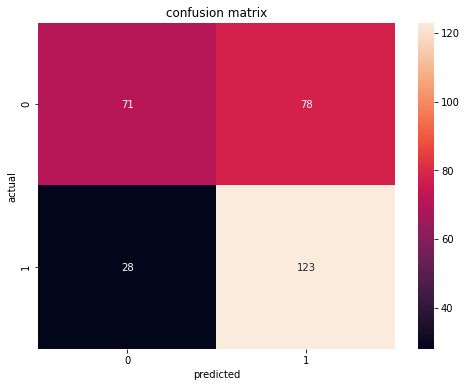

In [175]:
output_score, y_true, output_list = eval_joint_model(best_joint_model, criterion, threshold = 0.5, eval_set = 'test')

In [172]:
#unfreeze the CNN weights
joint_model, criterion, optimizer, scheduler = get_joint_model(cnn_path = '/content/drive/MyDrive/DL_models/KL_based_vgg.pt', freeze_cnn=False)
best_joint_model, train_acc_hist, val_acc_hist = train_joint_model(joint_model, criterion, optimizer, scheduler, freeze_cnn=False, threshold = 0.5, num_epochs=20)

<All keys matched successfully>
Adjusting learning rate of group 0 to 5.0000e-05.
Epoch 0/19
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 0.5707 Acc: 0.6912
val Loss: 0.6803 Acc: 0.6533, AUC: 0.7148
Epoch 1/19
----------
Adjusting learning rate of group 0 to 5.0000e-05.
train Loss: 0.5083 Acc: 0.7506
val Loss: 0.6850 Acc: 0.6400, AUC: 0.6886
Epoch 2/19
----------
Adjusting learning rate of group 0 to 4.0000e-05.
train Loss: 0.4721 Acc: 0.7714
val Loss: 0.6787 Acc: 0.6400, AUC: 0.7071
Epoch 3/19
----------
Adjusting learning rate of group 0 to 4.0000e-05.
train Loss: 0.4234 Acc: 0.8048
val Loss: 0.7432 Acc: 0.6133, AUC: 0.6823
Epoch 4/19
----------
Adjusting learning rate of group 0 to 4.0000e-05.
train Loss: 0.3658 Acc: 0.8405
val Loss: 0.7779 Acc: 0.6367, AUC: 0.6964
Epoch 5/19
----------
Adjusting learning rate of group 0 to 3.2000e-05.
train Loss: 0.3104 Acc: 0.8748
val Loss: 0.8527 Acc: 0.6267, AUC: 0.7020
Epoch 6/19
----------
Adjusting learning rate of

In [176]:
PATH = '/content/drive/MyDrive/DL_models/joint_vgg_model.pt'
torch.save(model_ft.state_dict(), PATH)